In [1]:
import numpy as np
import time
import pickle
import utils as Utils
import pandas as pd
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
# import modules.model as Model
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE 
# import modules.processor as Processor
# import modules.utils as Utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
# import xgboost as xgb
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm

In [2]:
train_data = pd.read_csv("../../Final_data/preprocessed/filtered/split_data_without_mhc/test/train.csv")
train_data

,CDR3b,epitope,binder
0,ASSPQGHEQYV,KLGGALQAK,1
1,ASFVTGNPNTEAF,KLSYGIATV,1
2,ASSLAPGLGHNEQF,LVVDFSQFSR,1
3,ASCAQMEQF,YVLDHLIVV,1
4,ASRPFLDRGDYGYT,AVFDRKSDAK,1
...,...,...,...
321360,ASSPGTGRGYT,IPSINVHHY,0
321361,ASSSTGESQPQH,CYTWNQMNL,0
321362,ASSSESPGELF,RAKFKQLL,0
321363,ASTTGAIYEQY,KTWGQYWQV,0


In [3]:
train_data_epi = train_data.epitope.unique()
print(len(train_data_epi))

507


In [4]:
train_data.binder.value_counts()

0    314681
1      6684
Name: binder, dtype: int64

In [5]:
test_data = pd.read_csv("../../Final_data/preprocessed/filtered/split_data_without_mhc/full_test.csv")
test_data

,CDR3b,epitope,binder
0,ASSASGGYEQY,FLRGRAYGL,0
1,ASSQDGYNEQF,ALIAPVHAV,0
2,ASSLALRVTDTQY,ELRRKMMYM,0
3,ASSPQLAAFNYGYT,RTLNAWVKV,0
4,ASSQGVGTEVG,AVFDRKSDAK,0
...,...,...,...
2933716,ASSLGSGGEVSYNEQF,RLRAEAQVK,0
2933717,ASRDGTEAF,STEGGGLAY,0
2933718,ASSQDSGGANEQF,CLLGTYTQDV,0
2933719,ASSYSAGSTEAF,KVAELVHFL,0


In [6]:
# int_df = pd.merge(train_data, test_data, how='inner', on=['CDR3b', 'epitope'])
# int_df

In [7]:
test_data_epi = test_data.epitope.unique()
len(test_data_epi)

1612

In [8]:
test_data = test_data[~test_data.epitope.isin(train_data_epi)]
test_data

,CDR3b,epitope,binder
184,ASSGGQASSYNEQF,GIAARVKNWL,1
987,ASSFEPRRQY,IMMNVAKYT,1
1081,ASSRTRVRNEQF,WEAKPSRIL,1
1423,ASSGRQGIDTEAF,YIFLGNLAL,1
1856,ASLQDYEQY,NVFAFPFTI,1
...,...,...,...
2870550,ASRRGSLELV,QLSSLGLNAV,1
2870643,ASSQDGQGVFETQY,LLAMTVPNV,1
2870658,SARGGARNTEAF,RTAPHGHVV,1
2870742,ASSPQSEGSYFTGELF,YYRRATRRIR,1


In [9]:
test_data.epitope.value_counts()

RLPGVLPRA      47
ILTGLNYEV      42
TFYLTNDVSFL    37
MMISAGFSL      33
ALYGFVPVL      32
               ..
LQAGNATEV       1
TLFTMVGTV       1
IPLTTAAKL       1
KMFDAYVNT       1
KAANIVLTV       1
Name: epitope, Length: 1151, dtype: int64

In [10]:
dataset_trb_neg = pd.read_csv("./process_data/data/final/dataset_trb_neg.csv")
dataset_trb_neg

,CDR3b,epitope,HLA,dataset,Species,disease,binder,Pathogen_source
0,AISDPGLAGGGGEQF,VTEHDTLLY,A0101,10x_neg,Human,CMV,0,virus
1,ASDTPVGQF,VTEHDTLLY,A0101,10x_neg,Human,CMV,0,virus
2,ASSGGSISTDTQY,VTEHDTLLY,A0101,10x_neg,Human,CMV,0,virus
3,ASSGGQSSYEQY,VTEHDTLLY,A0101,10x_neg,Human,CMV,0,virus
4,ASSQDPAGGYNEQF,VTEHDTLLY,A0101,10x_neg,Human,CMV,0,virus
...,...,...,...,...,...,...,...,...
3515834,SATGQETQY,AAKGRGAAL,NR(B0801),10x_neg,Human,NC,0,other
3515835,ASRNGALNTEAF,AAKGRGAAL,NR(B0801),10x_neg,Human,NC,0,other
3515836,ASSHGSFPYEQY,AAKGRGAAL,NR(B0801),10x_neg,Human,NC,0,other
3515837,ATSGTENTGELF,AAKGRGAAL,NR(B0801),10x_neg,Human,NC,0,other


In [11]:
dataset_trb_pos = pd.read_csv("./process_data/data/final/dataset_trb_pos.csv")
dataset_trb_pos

<ipython-input-11-c10c93b38f9e>:1: DtypeWarning: Columns (5,6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_trb_pos = pd.read_csv("./process_data/data/final/dataset_trb_pos.csv")


,CDR3b,epitope,HLA,dataset,Species,Category,Pathology,binder,Pathogen_source,disease,verification,validation,identification
0,ASSDAGANTEV,IKAVYNFATCG,H-2db,McPAS,Mouse,Pathogens,Lymphocytic choriomeningitis virus (LCMV),1,virus,NaN,NaN,NaN,NaN
1,ASSDAGAYAEQ,IKAVYNFATCG,H-2db,McPAS,Mouse,Pathogens,Lymphocytic choriomeningitis virus (LCMV),1,virus,NaN,NaN,NaN,NaN
2,ASSDAGGAAEV,IKAVYNFATCG,H-2db,McPAS,Mouse,Pathogens,Lymphocytic choriomeningitis virus (LCMV),1,virus,NaN,NaN,NaN,NaN
3,ASSDAGHSPLY,IKAVYNFATCG,H-2db,McPAS,Mouse,Pathogens,Lymphocytic choriomeningitis virus (LCMV),1,virus,NaN,NaN,NaN,NaN
4,ASSDAWGGAEQY,IKAVYNFATCG,H-2db,McPAS,Mouse,Pathogens,Lymphocytic choriomeningitis virus (LCMV),1,virus,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78342,ASSQDRGGQETQY,AVFDRKSDAK,A1101,10x_pos,Human,NaN,NaN,1,virus,EBV,NaN,NaN,NaN
78343,ASSLWRNTEAF,AVFDRKSDAK,A1101,10x_pos,Human,NaN,NaN,1,virus,EBV,NaN,NaN,NaN
78344,AWSVSEQF,AYAQKIFKI,A2402,10x_pos,Human,NaN,NaN,1,virus,CMV,NaN,NaN,NaN
78345,ASRFSPGENTEAF,QYDPVAALF,A2402,10x_pos,Human,NaN,NaN,1,virus,CMV,NaN,NaN,NaN


In [12]:
mcpas_trb = pd.read_csv("./process_data/data/final/mcpas_trb.csv")
tbadb_trb = pd.read_csv("./process_data/data/final/tbadb_trb.csv")
vdjdb_trb = pd.read_csv("./process_data/data/final/vdjdb_trb.csv")
trb_10x_pos = pd.read_csv("./process_data/data/final/trb_10x_pos.csv")
trb_10x_neg = pd.read_csv("./process_data/data/final/trb_10x_neg.csv")


trb_10x_pos

,CDR3b,epitope,HLA,dataset,Species,disease,binder,Pathogen_source
0,ASSLLGGTIDTQY,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
1,SASQGLNTGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
2,ASSLGLEGTNQPQH,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
3,ASSLSGGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
4,ASSLGGGTGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
...,...,...,...,...,...,...,...,...
20219,ASSQDRGGQETQY,AVFDRKSDAK,A1101,10x_pos,Human,EBV,1,virus
20220,ASSLWRNTEAF,AVFDRKSDAK,A1101,10x_pos,Human,EBV,1,virus
20221,AWSVSEQF,AYAQKIFKI,A2402,10x_pos,Human,CMV,1,virus
20222,ASRFSPGENTEAF,QYDPVAALF,A2402,10x_pos,Human,CMV,1,virus


In [67]:
# tbadb_tra.Pathogen_source.value_counts()

In [13]:
test_data_mcpas = pd.merge(test_data, mcpas_trb, how='inner', on=['CDR3b', 'epitope', 'binder'])
test_data_mcpas

,CDR3b,epitope,binder,HLA,dataset,Species,Category,Pathology,Pathogen_source
0,SVDLGTEETQY,FMIGYTSAL,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
1,SATLDRNYGYT,LLAGTLAVV,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
2,ASSLGNTEAF,FLYNPLTRV,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
3,ASSTSAANQPQH,NLQREEYTV,1,HLA-A*02:01,McPAS,Human,Cancer,Neoantigen,human
4,ASSLVAGPYSQETQY,MMPFSIVYI,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
...,...,...,...,...,...,...,...,...,...
541,ASSLAQSDSLAF,RMAAISNTV,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
542,ASSQNGSEAAYSNQPQH,VQYLGMFPV,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
543,ASSLGQGTYEQY,LLFALHFSA,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human
544,ASSQDGQGVFETQY,LLAMTVPNV,1,HLA-A2,McPAS,Human,Cancer,Neoantigen,human


In [14]:
test_data_mcpas.Pathogen_source.value_counts()

human         499
virus          25
autoimmune     20
Name: Pathogen_source, dtype: int64

In [15]:
test_data_tbadb = pd.merge(test_data, tbadb_trb, how='inner', on=['CDR3b', 'epitope', 'binder'])
test_data_tbadb

,CDR3b,epitope,binder,HLA,dataset,Species,disease,verification,Pathogen_source,validation
0,AISERAIRGTSGLTDTQY,TQGYFPDWQNY,1,B*57:03,TBAdb,Homo Sapiens,Human immunodeficiency virus (HIV),Selection of antigen- specific T cells using p...,virus,True
1,ASSLAQAGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
2,ASSLAQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
3,ASSQAQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
4,ASSPGGGKETQY,DEEDAIAAY,1,A-B*18,TBAdb,Homo Sapiens,CMV,Antigen-specific ex vivo proliferation,virus,True
5,ASSLGQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
6,ASSLSQGAETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
7,ASSLSQGGRPM,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
8,ASRMNTEA,ALTPVVVTL,1,A*02:01,TBAdb,Homo Sapiens,Acute myeloid leukaemia,Selection of antigen- specific T cells using p...,human,True
9,ASSQAAGGRA,TQGYFPDWQNY,1,B*57:03,TBAdb,Homo Sapiens,Human immunodeficiency virus (HIV),Selection of antigen- specific T cells using p...,virus,True


In [16]:
test_data_tbadb.Pathogen_source.value_counts()

virus         16
autoimmune    14
human          6
Name: Pathogen_source, dtype: int64

In [17]:
len(test_data_tbadb[test_data_tbadb.validation == True].epitope.unique())

7

In [18]:
test_data_vdjdb = pd.merge(test_data, vdjdb_trb, how='inner', on=['CDR3b', 'epitope', 'binder'])
test_data_vdjdb

,CDR3b,epitope,binder,HLA,dataset,Species,Category,identification,verification,Pathogen_source,validation
0,ASSFEPRRQY,IMMNVAKYT,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1,ASLQDYEQY,NVFAFPFTI,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
2,ASSRKAYEQY,VPYFNMVYM,1,HLA-B*07:02,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
3,ASSLGLAPGYEQY,LITGRLQSL,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
4,ASSEDNRGRYEQY,VFLVLLPLV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
...,...,...,...,...,...,...,...,...,...,...,...
1658,ASSPVSYNEQF,NVFAFPFTI,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1659,ATSETVAGGTGELF,YIDIGNYTV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1660,ASRGLGRADTQY,AIFYLITPV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1661,ASSPLVRGDEQF,CPACYNSEV,1,HLA-B*07:02,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True


In [19]:
test_data_vdjdb.identification.value_counts()

tetramer-sort                                          1331
dextramer-sort                                           90
antigen-expressing-targets                               54
antigen-loaded-targets                                   38
dextramer-sort,cultured-T-cells                          29
multimer-sort                                            16
cultured-T-cells,dextramer-sort                          12
pentamer-sort                                             9
cultured-T-cells,tetramer-sort                            8
antigen-loaded-targets,cloning-by-limiting-dilution       8
limited-dilution-cloning,antigen-expressing-targets       5
tetramer sort                                             3
antigen-loaded-targets,limiting-dilution-cloning          2
Name: identification, dtype: int64

In [20]:
test_data_vdjdb.verification.value_counts()

antigen-expressing-targets                   110
antigen-loaded-targets                        88
tetramer-stain,antigen-loaded-targets         12
tetramer-sort                                  7
multimer-staining, antigen-loaded-targets      3
CTL clone                                      1
multimer-sort,antigen-loaded-targets           1
Name: verification, dtype: int64

In [21]:
len(test_data_vdjdb[test_data_vdjdb.validation == True])

1663

In [22]:
test_data_10x_pos = pd.merge(test_data, trb_10x_pos, how='inner', on=['CDR3b', 'epitope', 'binder'])
test_data_10x_pos

,CDR3b,epitope,binder,HLA,dataset,Species,disease,Pathogen_source


In [23]:
test_data_10x_neg = pd.merge(test_data, trb_10x_neg, how='inner', on=['CDR3b', 'epitope', 'binder'])
test_data_10x_neg

,CDR3b,epitope,binder,HLA,dataset,Species,disease,Pathogen_source


In [24]:
len(test_data.epitope.unique())

1151

In [25]:
test_data_vdjdb

,CDR3b,epitope,binder,HLA,dataset,Species,Category,identification,verification,Pathogen_source,validation
0,ASSFEPRRQY,IMMNVAKYT,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1,ASLQDYEQY,NVFAFPFTI,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
2,ASSRKAYEQY,VPYFNMVYM,1,HLA-B*07:02,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
3,ASSLGLAPGYEQY,LITGRLQSL,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
4,ASSEDNRGRYEQY,VFLVLLPLV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
...,...,...,...,...,...,...,...,...,...,...,...
1658,ASSPVSYNEQF,NVFAFPFTI,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1659,ATSETVAGGTGELF,YIDIGNYTV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1660,ASRGLGRADTQY,AIFYLITPV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True
1661,ASSPLVRGDEQF,CPACYNSEV,1,HLA-B*07:02,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True


In [26]:
pd.merge(test_data_vdjdb, test_data_mcpas, how='inner', on=['CDR3b', 'epitope', 'binder']).epitope.unique()

array(['TQGYFPDWQNY', 'YLEPGPVTA', 'ALTPVVVTL'], dtype=object)

In [27]:
pd.merge(test_data_tbadb, test_data_mcpas, how='inner', on=['CDR3b', 'epitope', 'binder']).epitope.unique()

array(['TQGYFPDWQNY', 'FWIDLFETIG', 'ALTPVVVTL'], dtype=object)

In [29]:
pd.merge(test_data_tbadb, test_data_vdjdb, how='inner', on=['CDR3b', 'epitope', 'binder']).epitope.unique()

array(['TQGYFPDWQNY', 'DEEDAIAAY', 'ELKRKMIYM', 'CVETMCNEY', 'EENLLDFVRF',
       'ALTPVVVTL'], dtype=object)

In [30]:
test_data_vdjdb.binder.value_counts()

1    1663
Name: binder, dtype: int64

In [31]:
test_data.binder.value_counts()

1    3348
Name: binder, dtype: int64

In [32]:
test_data

,CDR3b,epitope,binder
184,ASSGGQASSYNEQF,GIAARVKNWL,1
987,ASSFEPRRQY,IMMNVAKYT,1
1081,ASSRTRVRNEQF,WEAKPSRIL,1
1423,ASSGRQGIDTEAF,YIFLGNLAL,1
1856,ASLQDYEQY,NVFAFPFTI,1
...,...,...,...
2870550,ASRRGSLELV,QLSSLGLNAV,1
2870643,ASSQDGQGVFETQY,LLAMTVPNV,1
2870658,SARGGARNTEAF,RTAPHGHVV,1
2870742,ASSPQSEGSYFTGELF,YYRRATRRIR,1


## Predict 

In [58]:
len(train_data.epitope.unique())

507

In [33]:
def data_representation_blosum62(X_data):
    encoding = Utils.blosum62_20aa
    
    m_cdr3 = Utils.enc_list_bl_max_len(X_data.CDR3b, encoding, 19)
    m_cdr3 = m_cdr3.reshape(len(m_cdr3), 380)
    
    m_epitope = Utils.enc_list_bl_max_len(X_data.epitope, encoding, 11)
    m_epitope = m_epitope.reshape(len(m_epitope), 220)
    
    df_res1 = pd.DataFrame(m_cdr3)
    df_res2 = pd.DataFrame(m_epitope)
    
    res = pd.concat([df_res1, df_res2], axis=1)
    
    return res

In [34]:
model_rf = "../../Improve_model/combine_model/models/1_model_rf_blosum62.pkl"
model_rf = pickle.load(open(model_rf, 'rb'))

In [63]:
len(test_data_tbadb.epitope.unique())

7

In [64]:
test_data_tbadb

,CDR3b,epitope,binder,HLA,dataset,Species,disease,verification,Pathogen_source,validation
0,AISERAIRGTSGLTDTQY,TQGYFPDWQNY,1,B*57:03,TBAdb,Homo Sapiens,Human immunodeficiency virus (HIV),Selection of antigen- specific T cells using p...,virus,True
1,ASSLAQAGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
2,ASSLAQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
3,ASSQAQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
4,ASSPGGGKETQY,DEEDAIAAY,1,A-B*18,TBAdb,Homo Sapiens,CMV,Antigen-specific ex vivo proliferation,virus,True
5,ASSLGQGGETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
6,ASSLSQGAETQY,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
7,ASSLSQGGRPM,FWIDLFETIG,1,DPB1*02:01,TBAdb,Homo Sapiens,Allergy,Selection of antigen- specific T cells using p...,autoimmune,True
8,ASRMNTEA,ALTPVVVTL,1,A*02:01,TBAdb,Homo Sapiens,Acute myeloid leukaemia,Selection of antigen- specific T cells using p...,human,True
9,ASSQAAGGRA,TQGYFPDWQNY,1,B*57:03,TBAdb,Homo Sapiens,Human immunodeficiency virus (HIV),Selection of antigen- specific T cells using p...,virus,True


In [35]:
test_data_3data = pd.concat([test_data_vdjdb, test_data_mcpas, test_data_tbadb], axis=0)
test_data_3data = test_data_3data.drop_duplicates(subset=["CDR3b", "epitope", "binder"]).reset_index(drop=True)
test_data_3data

,CDR3b,epitope,binder,HLA,dataset,Species,Category,identification,verification,Pathogen_source,validation,Pathology,disease
0,ASSFEPRRQY,IMMNVAKYT,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True,NaN,NaN
1,ASLQDYEQY,NVFAFPFTI,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True,NaN,NaN
2,ASSRKAYEQY,VPYFNMVYM,1,HLA-B*07:02,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True,NaN,NaN
3,ASSLGLAPGYEQY,LITGRLQSL,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True,NaN,NaN
4,ASSEDNRGRYEQY,VFLVLLPLV,1,HLA-A*02:01,VDJdb,HomoSapiens,SARS-CoV-2,tetramer-sort,NaN,virus,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,ASSQNGSEAAYSNQPQH,VQYLGMFPV,1,HLA-A2,McPAS,Human,Cancer,NaN,NaN,human,NaN,Neoantigen,NaN
2190,ASSLGQGTYEQY,LLFALHFSA,1,HLA-A2,McPAS,Human,Cancer,NaN,NaN,human,NaN,Neoantigen,NaN
2191,ASSQDGQGVFETQY,LLAMTVPNV,1,HLA-A2,McPAS,Human,Cancer,NaN,NaN,human,NaN,Neoantigen,NaN
2192,ASSSGYNEQF,VLLGVKLFGV,1,HLA-A2,McPAS,Human,Cancer,NaN,NaN,human,NaN,Neoantigen,NaN


In [36]:
pX_test = data_representation_blosum62(test_data_3data)

In [37]:
y_rf_test_pred = model_rf.predict(pX_test)
y_rf_test_proba = model_rf.predict_proba(pX_test)
df_test_rf = pd.DataFrame(data = y_rf_test_proba, columns = ["tmp", "predict_proba"])

df_test_rf = df_test_rf[["predict_proba"]]
df_prob_test_rf = pd.concat([test_data_3data, df_test_rf], axis=1)

In [38]:
y_binder = test_data_3data.iloc[:, lambda test_data_3data: [2]]
y_binder

,binder
0,1
1,1
2,1
3,1
4,1
...,...
2189,1
2190,1
2191,1
2192,1


In [39]:
_, fp, fn, tp = confusion_matrix(y_binder, y_rf_test_pred).ravel()
print('Sensitivity (TPR): ', tp/(tp+fn))

Sensitivity (TPR):  0.9990884229717412


In [40]:
trb_10x_pos

,CDR3b,epitope,HLA,dataset,Species,disease,binder,Pathogen_source
0,ASSLLGGTIDTQY,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
1,SASQGLNTGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
2,ASSLGLEGTNQPQH,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
3,ASSLSGGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
4,ASSLGGGTGELF,KTWGQYWQV,A0201,10x_pos,Human,Cancer,1,human
...,...,...,...,...,...,...,...,...
20219,ASSQDRGGQETQY,AVFDRKSDAK,A1101,10x_pos,Human,EBV,1,virus
20220,ASSLWRNTEAF,AVFDRKSDAK,A1101,10x_pos,Human,EBV,1,virus
20221,AWSVSEQF,AYAQKIFKI,A2402,10x_pos,Human,CMV,1,virus
20222,ASRFSPGENTEAF,QYDPVAALF,A2402,10x_pos,Human,CMV,1,virus


In [41]:
test_cb_26 = pd.read_csv("../../Improve_model/combine_model/data_test/pmtnet_v2.csv")
test_cb_26_1 = pd.read_csv("../../Improve_model/combine_model/data_test/pmtnet_paper1_v2.csv")
test_cb_26 = test_cb_26[test_cb_26["binder"] == 0]
 
test_cb_26 = test_cb_26.reset_index(drop=True)
 
ptest_cb_26  = pd.concat([test_cb_26, test_cb_26_1], axis=0)
ptest_cb_26 = ptest_cb_26[~ptest_cb_26.epitope.isin(train_data_epi)]
ptest_cb_26  = ptest_cb_26.reset_index(drop=True)

ptest_cb_26 

,CDR3b,epitope,binder
0,ASRPGQVVYGYT,FLTVFSHFM,0
1,ASRPGQVVYGYT,ALIHHNTYL,0
2,ASRPGQVVYGYT,ILIVMFPFL,0
3,ASRPGQVVYGYT,LLAGTLAVV,0
4,ASRPGQVVYGYT,LLAILTYYV,0
...,...,...,...
15553,SAHRAGTSGADYNEQF,SLLWMNLFV,1
15554,ASSIRVSGANVLT,SLLWMNLFV,1
15555,ASSYGGSSYEQY,SLLWMNLFV,1
15556,ATSFSRMANEKLF,SLLWMNLFV,1


In [42]:
ptest_cb_26["len"] = ptest_cb_26.epitope.str.len()
ptest_cb_26 = ptest_cb_26[(ptest_cb_26["len"] <= 11) & (ptest_cb_26["len"] >= 8)]
ptest_cb_26["len_cdr3"] = ptest_cb_26.CDR3b.str.len()
ptest_cb_26 = ptest_cb_26[(ptest_cb_26["len_cdr3"] <= 19) & (ptest_cb_26["len_cdr3"] >= 8)]
ptest_cb_26 = ptest_cb_26.drop(['len', 'len_cdr3'], axis=1)
ptest_cb_26 = ptest_cb_26.reset_index(drop=True)
ptest_cb_26

<ipython-input-42-fbf471ddfac0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptest_cb_26["len_cdr3"] = ptest_cb_26.CDR3b.str.len()


,CDR3b,epitope,binder
0,ASRPGQVVYGYT,FLTVFSHFM,0
1,ASRPGQVVYGYT,ALIHHNTYL,0
2,ASRPGQVVYGYT,ILIVMFPFL,0
3,ASRPGQVVYGYT,LLAGTLAVV,0
4,ASRPGQVVYGYT,LLAILTYYV,0
...,...,...,...
15551,SAHRAGTSGADYNEQF,SLLWMNLFV,1
15552,ASSIRVSGANVLT,SLLWMNLFV,1
15553,ASSYGGSSYEQY,SLLWMNLFV,1
15554,ATSFSRMANEKLF,SLLWMNLFV,1


In [43]:
ptest_cb_26.to_csv("../../Improve_model/combine_model/data_test/ptest_cb_26.csv")

In [44]:
pX_test = data_representation_blosum62(ptest_cb_26)

pX_test

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15551,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15552,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15553,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15554,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

              precision    recall  f1-score   support

  Non-binder       0.00      0.00      0.00     15264
      Binder       0.02      1.00      0.04       292

    accuracy                           0.02     15556
   macro avg       0.01      0.50      0.02     15556
weighted avg       0.00      0.02      0.00     15556



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


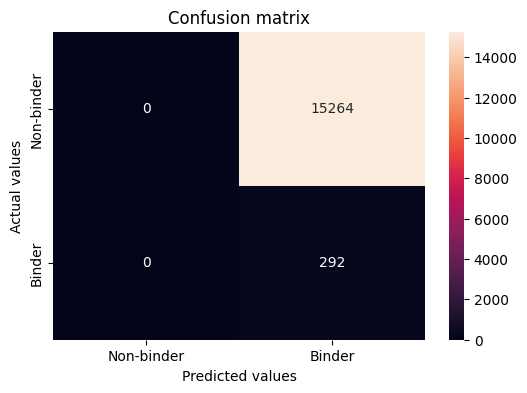

Accuracy score  :  0.018770892260221137
Sensitivity (TPR):  1.0
Specificity (TNR):  0.0
AUC :  0.5175816586973379


In [46]:
y_rf_test_proba21 = model_rf.predict_proba(pX_test)
df_test_rf21 = pd.DataFrame(data = y_rf_test_proba21, columns = ["tmp", "predict_proba"])

df_test_rf21 = df_test_rf21[["predict_proba"]]
df_prob_test_rf21 = pd.concat([ptest_cb_26, df_test_rf21], axis=1)
df_prob_test_rf21['binder_pred'] = np.where(df_prob_test_rf21['predict_proba'] >= 0.5, 1, 0)

y_test02 = df_prob_test_rf21["binder"].to_numpy()
y_test02_pred = df_prob_test_rf21["binder_pred"].to_numpy()

confusionMatrix(y_test02, y_test02_pred)

tn02, fp02, fn02, tp02 = confusion_matrix(y_test02, y_test02_pred).ravel()
accuracy02 = float(accuracy_score(y_test02, y_test02_pred).ravel())
sensitivity02 = tp02/(tp02+fn02)
specificity02 = tn02/(tn02+fp02)
auc02 = metrics.roc_auc_score(y_test02, df_prob_test_rf21["predict_proba"])
print ("Accuracy score  : ", accuracy02)
print('Sensitivity (TPR): ', sensitivity02)
print('Specificity (TNR): ', specificity02)
print ("AUC : ", auc02)

In [53]:
df_prob_test_rf21["binder"].value_counts()

0    15264
1      292
Name: binder, dtype: int64

In [47]:
df_prob_test_rf21

,CDR3b,epitope,binder,predict_proba,binder_pred
0,ASRPGQVVYGYT,FLTVFSHFM,0,0.980783,1
1,ASRPGQVVYGYT,ALIHHNTYL,0,0.820870,1
2,ASRPGQVVYGYT,ILIVMFPFL,0,0.925988,1
3,ASRPGQVVYGYT,LLAGTLAVV,0,0.693942,1
4,ASRPGQVVYGYT,LLAILTYYV,0,0.945782,1
...,...,...,...,...,...
15551,SAHRAGTSGADYNEQF,SLLWMNLFV,1,0.925168,1
15552,ASSIRVSGANVLT,SLLWMNLFV,1,0.956384,1
15553,ASSYGGSSYEQY,SLLWMNLFV,1,0.940455,1
15554,ATSFSRMANEKLF,SLLWMNLFV,1,0.940604,1


In [48]:
out_ptest_rf_cnn_21 = pd.read_csv("../../Tools/NetTCR-2.0/output_prediction.csv")
out_ptest_rf_cnn_21['binder'] = out_ptest_rf_cnn_21['binder'].astype(int)
out_ptest_rf_cnn_21['binder_pred'] = np.where(out_ptest_rf_cnn_21['prediction'] >= 0.5, 1, 0)

out_ptest_rf_cnn_21

,Unnamed: 0,CDR3b,peptide,binder,prediction,binder_pred
0,0,ASRPGQVVYGYT,FLTVFSHFM,0,0.006278,0
1,1,ASRPGQVVYGYT,ALIHHNTYL,0,0.021346,0
2,2,ASRPGQVVYGYT,ILIVMFPFL,0,0.006739,0
3,3,ASRPGQVVYGYT,LLAGTLAVV,0,0.002686,0
4,4,ASRPGQVVYGYT,LLAILTYYV,0,0.003985,0
...,...,...,...,...,...,...
15551,15551,SAHRAGTSGADYNEQF,SLLWMNLFV,1,0.006343,0
15552,15552,ASSIRVSGANVLT,SLLWMNLFV,1,0.000052,0
15553,15553,ASSYGGSSYEQY,SLLWMNLFV,1,0.006839,0
15554,15554,ATSFSRMANEKLF,SLLWMNLFV,1,0.004738,0


In [49]:
(out_ptest_rf_cnn_21.peptide.unique())

array(['FLTVFSHFM', 'ALIHHNTYL', 'ILIVMFPFL', 'LLAGTLAVV', 'LLAILTYYV',
       'SLLWMNLFV', 'ALSYTPAEV', 'KMVAVFYNT', 'FMLYLLTLM', 'KLWASPLHV',
       'SLDLTTSPV', 'GLTSFFIAI', 'LLLNMLIVL', 'KLFEFLVYGV', 'YLWPPVQLA',
       'ALYGFVPVL', 'MLLKHDVSL', 'YLLAIFSGL', 'FMIGYTSAL', 'YLDELIRNT',
       'FLSDHLYLV', 'LLFGMPPCL', 'LIFNMLYWI', 'QLLVSLWGL', 'TLFTMVGTV',
       'LMVPHSPSL', 'NLFNRYLAL', 'KLANPLPYT', 'AMAGSLVFL', 'MIISHLYLI',
       'VLLGVKLFGV', 'YLQDSMATT', 'ILTGLNYEV', 'VQYLGMFPV', 'LLAMTVPNV',
       'TMSFSHLFYL', 'LLFALHFSA', 'LVFPLVMGV', 'LLIASVTWL', 'MMPFSIVYI',
       'ILITQVLGL', 'MMPFSIVYIV', 'KLMNIQQKL', 'ILNVDIFTL', 'MLSILALVRV',
       'YMLTLHTKL', 'FIFSYVVAV', 'FIYQYYSSI', 'FLNVLFPLL', 'RLHDLVFPL',
       'AVGSYVYSV', 'HIVEISTPV', 'KLSHQLVLL', 'ALLQVTLLL', 'FLASPSVPL',
       'KLPLDIDPV', 'FQLNQSFEI', 'KLNTITAVV', 'LMVLHSPSL', 'KLNTITPVV',
       'LLAMKVPNV', 'SLDPTTSPV', 'LVMPFSIVYI', 'FSSEVLNLV', 'LLAILPYYV',
       'NLFNRYPAL', 'ALSPVIPLI', 'RLWEPLRVV', 'VLNPFIYTL',

In [50]:
(df_prob_test_rf21.epitope.unique())

array(['FLTVFSHFM', 'ALIHHNTYL', 'ILIVMFPFL', 'LLAGTLAVV', 'LLAILTYYV',
       'SLLWMNLFV', 'ALSYTPAEV', 'KMVAVFYNT', 'FMLYLLTLM', 'KLWASPLHV',
       'SLDLTTSPV', 'GLTSFFIAI', 'LLLNMLIVL', 'KLFEFLVYGV', 'YLWPPVQLA',
       'ALYGFVPVL', 'MLLKHDVSL', 'YLLAIFSGL', 'FMIGYTSAL', 'YLDELIRNT',
       'FLSDHLYLV', 'LLFGMPPCL', 'LIFNMLYWI', 'QLLVSLWGL', 'TLFTMVGTV',
       'LMVPHSPSL', 'NLFNRYLAL', 'KLANPLPYT', 'AMAGSLVFL', 'MIISHLYLI',
       'VLLGVKLFGV', 'YLQDSMATT', 'ILTGLNYEV', 'VQYLGMFPV', 'LLAMTVPNV',
       'TMSFSHLFYL', 'LLFALHFSA', 'LVFPLVMGV', 'LLIASVTWL', 'MMPFSIVYI',
       'ILITQVLGL', 'MMPFSIVYIV', 'KLMNIQQKL', 'ILNVDIFTL', 'MLSILALVRV',
       'YMLTLHTKL', 'FIFSYVVAV', 'FIYQYYSSI', 'FLNVLFPLL', 'RLHDLVFPL',
       'AVGSYVYSV', 'HIVEISTPV', 'KLSHQLVLL', 'ALLQVTLLL', 'FLASPSVPL',
       'KLPLDIDPV', 'FQLNQSFEI', 'KLNTITAVV', 'LMVLHSPSL', 'KLNTITPVV',
       'LLAMKVPNV', 'SLDPTTSPV', 'LVMPFSIVYI', 'FSSEVLNLV', 'LLAILPYYV',
       'NLFNRYPAL', 'ALSPVIPLI', 'RLWEPLRVV', 'VLNPFIYTL',

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  Non-binder       0.98      1.00      0.99     15264
      Binder       0.00      0.00      0.00       292

    accuracy                           0.98     15556
   macro avg       0.49      0.50      0.50     15556
weighted avg       0.96      0.98      0.97     15556



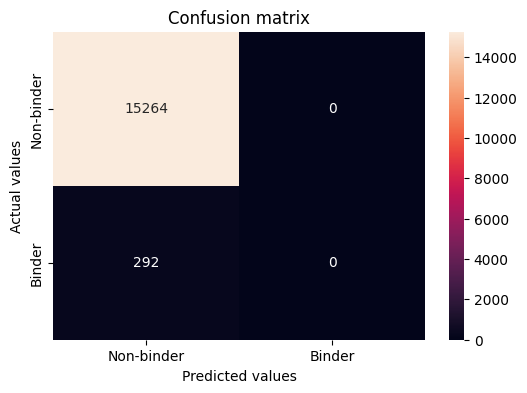

Accuracy score  :  0.9812291077397789
Sensitivity (TPR):  0.0
Specificity (TNR):  1.0
AUC :  0.47082130754429796


In [51]:
y_test = out_ptest_rf_cnn_21["binder"].to_numpy()
y_test_pred = out_ptest_rf_cnn_21["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, out_ptest_rf_cnn_21["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)